# Appian Data Categorization

Goal: Predict A and B (email categories) based on values C and D (subject and description). Essentially, I looked at emails and tried to classify them into categories. I used some serious regular expressions and cleaning of the subject line, then used Glove word embeddings and a neural net and achieved about 80% accuracy (unfortunately the net takes a long time to run). I also used tf-idf and achieved about 64% accuracy. For improvement, the model needs a LOT more emails to train on--some categories only had about 10 emails in them total! 


In [450]:
import pandas as pd
#import xgboost as xgb (this doesn't work but can fix later, neural nets are cooler anyway)
import numpy as np
from textblob import TextBlob
import string
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn import decomposition, ensemble
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import wordsegment
import os
import sys
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dense, Activation, Flatten
from keras.models import Model
from keras.initializers import Constant
import re
import nltk
import pycountry

In [451]:
# will need to change path later
data = pd.read_excel("HRTM_CASE.xlsx")

In [452]:
data.dropna(inplace = True)

In [453]:
Subject = []
Description = []
Subject.append("memes's are hello")
Description.append("we're tryna is ur eating isntworking and I cant believe that it wouldn't do that")

In [454]:
#data = pd.DataFrame({'Subject': Subject, 'Description': Description})

In [455]:
# use Cantor pairing function to find each unique category for emails to go in
data["Category"] = 1/2 * (data.KeyCategory + data.KeyServiceOffering) * (data.KeyCategory + data.KeyServiceOffering + 1) + data.KeyCategory

In [456]:
# label encode these categories
data["Category"] = data["Category"].astype('category').cat.codes

In [457]:
data_original = data

In [463]:
data["KeyCategory"].value_counts()

6.0     2269
12.0    2002
2.0     1961
4.0     1735
8.0     1188
5.0      784
1.0      501
10.0     314
13.0     157
7.0      121
11.0      52
3.0       34
Name: KeyCategory, dtype: int64

## Text Cleaning/Basic Features

In [409]:
# get rid of all emails with reply or FW in the subject line (we are just gonna do what we can, those are too hard)
indices = []

for i, row in data['Subject'].items():
    if re.match('^[A-Za-z]{2}:\s*', data["Subject"][i]):
        indices.append(i)
# match = re.search(pattern, string)
# if match:
#     process(match)

In [410]:
data = data.drop(indices)

In [411]:
len(data)

9173

In [412]:
data['Description'][11603];

In [413]:
# set everything to lower case
data['Description'] = data['Description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['Subject'] = data['Subject'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [414]:
# remove emails and special formatting stuff (must do this before we remove punctuation, or it will go away)
# remove emails
data['Description'] = data['Description'].str.replace('\S*@\S*\s?',' ')
data['Subject'] = data['Subject'].str.replace('\S*@\S*\s?',' ')
# remove urls, www. or http:// format
data['Description'] = data['Description'].str.replace('^https?:\/\/.*[\r\n]*', ' ')
data['Description'] = data['Description'].str.replace('\s\S*www.\S*\s', ' ')
data['Subject'] = data['Subject'].str.replace('^https?:\/\/.*[\r\n]*', ' ')
data['Subject'] = data['Subject'].str.replace('\s\S*www.\S*\s', ' ')

# remove everything in from, sent, and to fields (will do subject in next box)
# this one's only for description
data['Description'] = data['Description'].str.replace('from:\s.*?sent:\s', 'sent: ')
data['Description'] = data['Description'].str.replace('sent:\s.*?to:\s', 'to: ')
data['Description'] = data['Description'].str.replace('to:\s.*?subject:\s', ' ')

In [415]:
# remove the subject from the description (slow but we gotta do it) 
# the regex just removes a fw: or a re: from the subject line, since
# we don't have to match that part
# for i, row in data.iterrows():
#     text = re.sub('\S+:\s*','', row['Subject'])
#     if row['Description'].replace(text, '') != row['Description']:
#         data['Description'][i] = row['Description'].replace(text, ' ')

In [416]:
# # count number of dates in description
# def description_dates(x):
#     date1 = re.findall('\s*(19|20)*\d\d[- /.](0*[1-9]|1[012])[- /.](0*[1-9]|[12][0-9]|3[01])\s*', x["Description"])
#     date2 = re.findall('\s*(0*[1-9]|1[012])[- /.](0*[1-9]|[12][0-9]|3[01])[- /.](19|20)*\d\d\s*', x["Description"])
#     return (len(date1) + len(date2))

In [417]:
# data["DescriptionDates"] = data.apply(description_dates, axis = 1)

In [418]:
# # count number of dates in subject
# def subject_dates(x):
#     date1 = re.findall('\s*(19|20)*\d\d[- /.](0*[1-9]|1[012])[- /.](0*[1-9]|[12][0-9]|3[01])\s*', x.Subject)
#     date2 = re.findall('\s*(0*[1-9]|1[012])[- /.](0*[1-9]|[12][0-9]|3[01])[- /.](19|20)*\d\d\s*', x.Subject)
#     return (len(date1) + len(date2))

In [419]:
# data["SubjectDates"] = data.apply(subject_dates, axis = 1)

In [420]:
# replace any numerical dates with the word "date" so that we don't lose dates in the model 
data['Description'] = data["Description"].str.replace('\s*(19|20)*\d\d[- /.](0*[1-9]|1[012])[- /.](0*[1-9]|[12][0-9]|3[01])\s*', ' date ')
data['Description'] = data["Description"].str.replace('\s*(0*[1-9]|1[012])[- /.](0*[1-9]|[12][0-9]|3[01])[- /.](19|20)*\d\d\s*', ' date ')
data['Subject'] = data["Subject"].str.replace('\s*(19|20)*\d\d[- /.](0*[1-9]|1[012])[- /.](0*[1-9]|[12][0-9]|3[01])\s*', ' date ')
data['Subject'] = data["Subject"].str.replace('\s*(0*[1-9]|1[012])[- /.](0*[1-9]|[12][0-9]|3[01])[- /.](19|20)*\d\d\s*', ' date ')

In [421]:
# remove "___ floor" strings, then remove all words/terms with numbers in them
data['Description'] = data['Description'].str.replace("\s[a-zA-Z0-9]*\sfloor", " ")
data['Description'] = data['Description'].str.replace("\\w*[0-9]+\\w*\\s*", " ")

In [422]:
# remove all non alphabetical characters (punctuation, underscores, dashes, apostrophes, numbers, etc)
data['Description'] = data['Description'].str.replace("[^a-zA-Z]", " ")
data['Subject'] = data['Subject'].str.replace("[^a-zA-Z]", " ")

In [423]:
# remove excess spaces (important for what we're doing next)
data['Description'] = data["Description"].str.replace( '\s+', ' ')
data['Subject'] = data["Subject"].str.replace( '\s+', ' ')
# remove trailing whitespace
data['Description'] = data['Description'].str.strip()
data['Subject'] = data['Subject'].str.strip()

In [424]:
# regex to remove roads and streets
data['Description'] = data['Description'].str.replace("\s[a-zA-Z]*\scity", " ")
data['Description'] = data['Description'].str.replace("\s[a-zA-Z]*\sroad", " ")
data['Description'] = data['Description'].str.replace("\s[a-zA-Z]*\sstreet", " ")
# remove building number
data['Description'] = data["Description"].str.replace('building no', ' ')

In [425]:
6744     team request confirm good standing performance...
6796     good day sarah ramirez avega managed care woul...
7558

SyntaxError: invalid syntax (<ipython-input-425-5cde922696a3>, line 1)

In [ ]:
data['Description'][7558]

In [ ]:
# remove all the confidentiality messages and all that crap (don't have to worry about stopwords, 
# but it's worth doing this before we do the other stuff since we're looking for such specific patterns)
# also look at some stuff below the header that we can remove (there are a lot of offices, so this isn't the fastest)

#another message
data['Description'] = data["Description"].str.replace('email contains confidential information', ' ')
data['Description'] = data["Description"].str.replace('sole use of the intended recipient', ' ')
data['Description'] = data["Description"].str.replace('if you are not the intended recipient', ' ')
data['Description'] = data['Description'].str.replace('please contact the sender delete this email', ' ')
data['Description'] = data["Description"].str.replace('maintain the confidentiality of what you may have read', ' ')
data['Description'] = data["Description"].str.replace('save paper think before you print', ' ')

# and another
data['Description'] = data["Description"].str.replace('i am writing this letter to inform you of fadv messaging requirement', ' ')
data['Description'] = data["Description"].str.replace('please be informed that moving forward all messages will be encrypted', ' ')
data['Description'] = data["Description"].str.replace('compliance with the ra known as the data privacy act', ' ')
data['Description'] = data["Description"].str.replace('please do not hesitate to contact us if you need further information', ' ')

# and another message
data['Description'] = data["Description"].str.replace('information contained in this message', ' ')
data['Description'] = data["Description"].str.replace('intended only for the recipient', ' ')
data['Description'] = data["Description"].str.replace('may be a confidential attorney client communication or may otherwise be privileged and confidential and protected from disclosure', ' ')
data['Description'] = data["Description"].str.replace('reader of this message is not the intended recipient', ' ')
data['Description'] = data["Description"].str.replace('employee or agent responsible for delivering this message to the intended recipient', ' ')
data['Description'] = data["Description"].str.replace('please be aware that any dissemination or copying of this communication is strictly prohibited', ' ')
data['Description'] = data["Description"].str.replace('please immediately notify us by replying to the message and deleting it from your computer', ' ')

# kpmg india message
data['Description'] = data["Description"].str.replace('allows reasonable personal use of the e mail system', ' ')
data['Description'] = data["Description"].str.replace('views and opinions expressed in these communications', ' ')
data['Description'] = data["Description"].str.replace('do not necessarily represent those of kpmg', ' ')
data['Description'] = data["Description"].str.replace('disclaimer the information in this e mail is confidential and may be legally privileged', ' ')
data['Description'] = data["Description"].str.replace('it is intended solely for the addressee', ' ')
data['Description'] = data["Description"].str.replace('access to this e mail by anyone else is unauthorized', ' ')
data['Description'] = data["Description"].str.replace('if you have received this communication in error', ' ')
data['Description'] = data["Description"].str.replace('please address with the subject heading received in error send to then delete the e mail and destroy any copies of it', ' ')
data['Description'] = data["Description"].str.replace('if you are not the intended recipient', ' ')
data['Description'] = data["Description"].str.replace('any disclosure copying distribution', ' ')
data['Description'] = data["Description"].str.replace('any action taken or omitted to be taken in reliance on it is prohibited and may be unlawful', ' ')
data['Description'] = data["Description"].str.replace('any opinions or advice contained in this e mail are subject to the terms and conditions', ' ')
data['Description'] = data["Description"].str.replace('expressed in the governing kpmg client engagement letter', ' ')
data['Description'] = data["Description"].str.replace('opinions conclusions and other information in this e mail and any attachments that do not relate to the official business of the firm', ' ')
data['Description'] = data["Description"].str.replace('neither given nor endorsed by it', ' ')
data['Description'] = data["Description"].str.replace('kpmg cannot guarantee that e mail communications are secure or error free', ' ')
data['Description'] = data["Description"].str.replace('nformation could be intercepted corrupted amended lost destroyed arrive late or incomplete or contain viruses', ' ')
data['Description'] = data["Description"].str.replace('kpmg an indian partnership and a member firm of kpmg international cooperative', ' ')
data['Description'] = data["Description"].str.replace('kpmg international a swiss entity that serves as a coordinating entity for a network of independent firms operating under the kpmg name', ' ')
data['Description'] = data["Description"].str.replace('kpmg international cooperative ldquo kpmg international rdquo provides no services to clients', ' ')
data['Description'] = data["Description"].str.replace('each member firm of kpmg international cooperative ldquo', ' ')
data['Description'] = data["Description"].str.replace('kpmg international rdquo is a legally distinct and separate entity and each describes itself as such', ' ')

# US confidentiality message
data["Description"] = data["Description"].str.replace('this email was intended', ' ')
data["Description"] = data["Description"].str.replace('s p global market intelligence', ' ')
data["Description"] = data["Description"].str.replace('information contained in this message', ' ')
data["Description"] = data["Description"].str.replace(' intended only for the recipient', '')
data["Description"] = data["Description"].str.replace(' confidential attorney client communication', ' ')
data["Description"] = data["Description"].str.replace(' or may otherwise be', ' ')
data["Description"] = data["Description"].str.replace(' privileged and confidential and protected from disclosure', ' ')
data["Description"] = data["Description"].str.replace(' if the reader of this message is not the intended recipient', ' ')
data["Description"] = data["Description"].str.replace(' employee or agent responsible for delivering this message to the intended recipient', ' ')
data["Description"] = data["Description"].str.replace(' please be aware that any dissemination or copying of this communication is strictly prohibited', ' ')
data["Description"] = data["Description"].str.replace(' if you have received this communication in error please immediately notify us by replying to the message and deleting it from your computer', ' ')
data["Description"] = data["Description"].str.replace(' s p global inc reserves the right subject to applicable local law', ' ')
data["Description"] = data["Description"].str.replace(' monitor review and process the content of any electronic message or information', ' ')
data["Description"] = data["Description"].str.replace(' sent to or from s p global inc e mail addresses', ' ')
data["Description"] = data["Description"].str.replace(' without informing the sender or recipient of the message', ' ')
data["Description"] = data["Description"].str.replace(' by sending electronic message or information to s p global inc e mail addresses', ' ')
data['Description'] = data["Description"].str.replace('you as the sender are consenting to s p global inc', ' ')
data['Description'] = data["Description"].str.replace('processing any of your personal data therein', ' ')

In [ ]:
# ^note that there may be more automated messages like this... different offices might have different messages

In [ ]:
# remove excess whitespace and space once again
data['Description'] = data["Description"].str.replace( '\s+', ' ')
data['Subject'] = data["Subject"].str.replace( '\s+', ' ')
data['Description'] = data['Description'].str.strip()
data['Subject'] = data['Subject'].str.strip()

In [ ]:
# remove countries, cities, and other subcountry names from data description, as well as phrases
geography = pd.read_csv("https://raw.githubusercontent.com/datasets/world-cities/master/data/world-cities.csv")

In [ ]:
# set everything to lower case, and get rid of special characters (since we did that to the original data)
names = pd.Series(geography['name'].unique())
countries = pd.Series(geography['country'].unique())
subcountries = pd.Series(geography['subcountry'].unique())

names = names.apply(lambda x: " ".join(x.lower() for x in x.split()))
countries = countries.apply(lambda x: " ".join(x.lower() for x in x.split()))
subcountries = subcountries.apply(lambda x: " ".join(x.lower() for x in str(x).split()))

# remove all non alphabetical characters (punctuation, underscores, dashes, apostrophes, numbers, etc)
names = names.str.replace("[^a-zA-Z]", " ")
countries = countries.str.replace("[^a-zA-Z]", " ")
subcountries = subcountries.str.replace("[^a-zA-Z]", " ")

In [ ]:
# NEED TO ELIMINATE DOUBLE SPACE

In [ ]:
# use a list of phrases to remove, then do a str.replace for all of them
remove = pd.concat([names, countries, subcountries], ignore_index = True)

In [ ]:
remove = remove.str.replace( '\s+', ' ')
remove = remove.str.strip()

In [ ]:
# remove stopwords and other super common words, as well as single word countries (may have to do a for loop for the double word countries)
# words that need to be removed: fw: re: to: from: sent: to: "hr operations", and any one letter things typos

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.update(("fw","re","subject","to","from","sent", "spg", "spgmi", "inc", 
             "spgi", "www", "com", "spgmi", "â", "global", "please", "may", "â", "hi", "hello", "thanks", "ã"
             "thank", "https", "spgr", "th", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o",
             "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "dear", "sir", "madam", "building", "floor", "twitter",
             "linkedin", "facebook", "google", "youtube", "you tube", "kpmg", "kindly", "tel", "regards"))
stop.update(remove)
,stop.update
data['Description'] = data['Description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['Subject'] = data['Subject'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [ ]:
# get a list of all the words used less than 10 times, and a list for words used 10 or more times 
# (a word should be in one list or the other)
vc = pd.Series(' '.join(data['Description'] + data['Subject']).split()).value_counts()
common = vc[vc >= 10].index
uncommon = vc[vc < 10].index
words = common.append(uncommon)

In [ ]:
# use word segmentation on all words used less than 10 times (they are often two words stuck together!)
# don't for the other terms

from wordsegment import load,segment
load()

# create an array to store correct (split) strings of uncommon words
corrections = []

# fill this array with a for loop
for i in range(len(common)):
    corrections.append(str.split(common[i]))
for j in range(len(uncommon)):
    corrections.append(segment(uncommon[j]))

In [ ]:
# convert to dictionary
dictionary = dict(zip(words, corrections))

In [ ]:
# apply dictionary to our data
data['Description'] = data['Description'].apply(lambda x: " ".join(" ".join(dictionary[x]) for x in x.split() if x in dictionary))
data['Subject'] = data['Subject'].apply(lambda x: " ".join(" ".join(dictionary[x]) for x in x.split() if x in dictionary))

In [ ]:
# # Use the same process with spell check. Check spelling on words used under 20 times.
# # (a word should be in one list or the other). Can tweak this and play with it!
# vc = pd.Series(' '.join(data['Description'] + data['Subject']).split()).value_counts()
# common = vc[vc >= 10].index
# uncommon = vc[vc < 10].index
# words = common.append(uncommon)

In [ ]:
# # re-initialize the corrections array to make another dictionary (should be faster for textblob, 
# # because of how the algorithm works, it looks for distance between a correctly spelled word)
# # or is just doing it the hard way faster?

# # note: this has to be run overnight, can then pickle your datafile for next time
# corrections = []

# # fill this array with a for loop
# for i in range(len(common)):
#     corrections.append(common[i])
# for j in range(len(uncommon)):
#     if len(uncommon[j]) < 6:
#         corrections.append(uncommon[j])
#     else:
#         corrections.append(str(TextBlob(uncommon[j]).correct()))

In [426]:
# # convert to dictionary
# dictionary = dict(zip(words, corrections))

In [427]:
# # apply dictionary to our data (slight difference in syntax)
# data['Description'] = data['Description'].apply(lambda x: " ".join(dictionary[x] for x in x.split() if x in dictionary))
# data['Subject'] = data['Subject'].apply(lambda x: " ".join(dictionary[x] for x in x.split() if x in dictionary))

In [428]:
# remove stopwords and other super common words one more time
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.update(("fw","re","subject","to","from","sent", "hr operations", "spg", "s&p", "s &p", "s& p", "spgmi", "inc", 
             "spgi", "www", "com", "spgmi", "â", "global", "please", "may", "â", "hi", "hello", "thanks", "ã"
             "thank", "https", "spgr", "th", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o",
             "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "dear", "sir", "madam", "building", "floor", "twitter",
             "linkedin", "facebook", "google", "youtube", "you tube", "kpmg", "kindly", "tel", "regards"))
stop.update(remove)
stop.update
data['Description'] = data['Description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['Subject'] = data['Subject'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [429]:
# lemmatize all the words (for whatever reason Bryan's worked better so I'm using Bryan's)

In [430]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

data['Description'] = data.apply(lambda x: lemmatize_text(x['Description']), axis = 1)
data['Description'] = data.apply(lambda x: " ".join(x["Description"]), axis = 1)

In [431]:
# get rid of least frequent terms? 

In [432]:
vc = pd.Series(' '.join(data['Description'] + data['Subject']).split()).value_counts()
uncommon = vc[vc < 2].index

data['Description'] = data['Description'].apply(lambda x: " ".join(x for x in x.split() if x not in uncommon))
data['Subject'] = data['Subject'].apply(lambda x: " ".join(x for x in x.split() if x not in uncommon))

In [433]:
# look for more things that we need to do!!!

In [434]:
data['Description'][152]

'team noticed unable enter time manually oct sunday nightshift attached screenshot error try enter time manually let know required info contact detail name vivek thakkar email address ein manager vishal radia department workplace service vivek thakkar'

In [435]:
for c in data:
    if data[c].dtype == 'object':
        print('Max length of column %s: %s\n' %  (c, data[c].map(len).max()))

Max length of column Subject: 99

Max length of column Description: 2314



In [436]:
data['Description'].loc[data["Description"].str.len() > 2000]

927      hr ops treat email level manager approval toge...
3949     team currently working team workday timesheets...
6744     team request confirm good standing performance...
6796     good day sarah ramirez avega managed care woul...
7558     background check hr team first advantage condu...
7917     chandramouli sneha represent employment screen...
8474     represent employment screening practice ofkpmg...
8822     ex employee needed get previous work experienc...
9175     info consultant greeting verification work exp...
9693     hr team hired received following email regardi...
9869     concern represent employment screening practic...
10164    represent employment screening practice curren...
10530    team raising service desk request provide expe...
10683    hrd team greeting first advantage private limi...
10828    team greeting day represent employment screeni...
11603    team greeting day represent employment screeni...
Name: Description, dtype: object

## Using Keras with Glove!

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [437]:
MAX_NB_WORDS = 14000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [438]:
data['Text'] = data['Subject'] + data['Description']
texts = data['Text']
labels = data['KeyCategory']

In [439]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data_num = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data_num.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set

indices = np.arange(data_num.shape[0])
np.random.shuffle(indices)
data_num = data_num[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data_num.shape[0])

x_train = data_num[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data_num[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Found 15767 unique tokens.
Shape of data tensor: (9173, 100)
Shape of label tensor: (9173, 14)


## Preparing Embedding Layer

In [440]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B/glove.6B.100d.txt'
word2vec_output_file = 'glove.6B/glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 100)

In [441]:
from gensim.models import KeyedVectors # load the Stanford GloVe model
filename = 'glove.6B/glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [442]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in model.index2word:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = model[word]

In [443]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [444]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
data_format = 'channels_first'
x = Conv1D(128, 5, activation='relu', data_format = 'channels_first')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu', data_format = 'channels_first')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu', data_format = 'channels_first')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels[0]), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# happy learning! (gotta increase this for SURE)
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=12, batch_size=512)

Train on 7339 samples, validate on 1834 samples
Epoch 1/12
7339/7339 [==============================] - 260s 35ms/step - loss: 2.2562 - acc: 0.1928 - val_loss: 2.0577 - val_acc: 0.2437
Epoch 2/12
7339/7339 [==============================] - 258s 35ms/step - loss: 2.0473 - acc: 0.2376 - val_loss: 2.1041 - val_acc: 0.1816
Epoch 3/12
7339/7339 [==============================] - 260s 35ms/step - loss: 1.9928 - acc: 0.2665 - val_loss: 2.0308 - val_acc: 0.2557
Epoch 4/12
7339/7339 [==============================] - 260s 35ms/step - loss: 1.9375 - acc: 0.2803 - val_loss: 1.9337 - val_acc: 0.3015
Epoch 5/12
3584/7339 [=============>................] - ETA: 2:10 - loss: 1.9189 - acc: 0.3147

KeyboardInterrupt: 

## Modeling a la Bryan

Ideas: Co-Occurence Matrix is really really good, but takes a LOT of memory. Uses SVD at its core, factorization, but needs to be stored somewhere with a lot of memory. Perhaps get this up and running on Domino?

Can do glove or word2vec (these should both do better than bryan's model, which is SVC on the tfidf whatever that means)

Continuous Bag of Words would be great, but it's gonna take a WHILE to train if not properly optimized. Probabalistic and low on memory which is all great. Skip-gram is also great, like CBOW but better at predicting dual contexts, etc.

In [364]:
# my split into training and testing datasets (ignore because we're copying Bryan)
# train_x, test_x, train_y, test_y = model_selection.train_test_split(data[['Subject', 'Description']], data['Category'])

Bryan's Method (just cut out his lemmatization because I'm already gonna do that)

In [365]:
data['Text'] = data['Subject'] + data['Description']

In [366]:
msg_train, msg_test, label_train, label_test = \
model_selection.train_test_split(data["Text"], data['KeyCategory'], test_size=0.2)
bow_transformer = CountVectorizer(max_features=3000).fit(msg_train)

In [367]:
messages_bow = bow_transformer.transform(msg_train)
tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)
# %time testmodel = GradientBoostingClassifier(learning_rate=0.01,max_depth=20, n_estimators=100,verbose=3).fit(messages_tfidf, label_train)
# testmodel = RandomForestClassifier(n_estimators=100,verbose=1,n_jobs=2).fit(messages_tfidf, label_train)
testmodel = LinearSVC().fit(messages_tfidf, label_train)

messages_bow = bow_transformer.transform(msg_test)
messages_tfidf = tfidf_transformer.transform(messages_bow)

all_predictions = testmodel.predict(messages_tfidf)

In [368]:
print (classification_report(label_test, all_predictions))

             precision    recall  f1-score   support

        1.0       0.30      0.25      0.27        79
        2.0       0.53      0.54      0.54       334
        3.0       1.00      0.29      0.44         7
        4.0       0.68      0.73      0.70       281
        5.0       0.72      0.65      0.69       107
        6.0       0.73      0.80      0.76       390
        7.0       0.53      0.32      0.40        25
        8.0       0.81      0.75      0.78       112
       10.0       0.38      0.20      0.26        71
       11.0       0.60      0.43      0.50         7
       12.0       0.65      0.70      0.67       388
       13.0       0.77      0.29      0.43        34

avg / total       0.64      0.64      0.64      1835



In [154]:
import os, sys, email,re
import numpy as np 
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
import wordcloud

# Network analysis
import networkx as nx

# NLP
from nltk.tokenize.regexp import RegexpTokenizer

from subprocess import check_output

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import LatentDirichletAllocation

import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.stem.porter import PorterStemmer

totally not stealing from this guy: https://www.kaggle.com/jaykrishna/topic-modeling-enron-email-dataset
check this one out too: https://www.kaggle.com/r11d12/email-classification

In [157]:
# will need to change path later
data = pd.read_excel("HRTM_CASE.xlsx")

In [158]:
data.dropna(inplace = True)

In [159]:
data.head()

,KeyCategory,KeyServiceOffering,Subject,Description
0,12.0,42.0,Change of Start Date for New Hire,"Hi Team,\n\nPlease kindly change the onboardin..."
3,4.0,12.0,Unable to change salary crediting account via ...,"Dear Sir/Madam,\n\nI tried to change the bank ..."
4,6.0,29.0,Inquiry About Health Check-up,"Hi,\n\nI have given blood samples for annual h..."
5,12.0,42.0,FW: Approval of Timesheets,"Hello team,\n\nSee below email from my manager..."
6,1.0,1.0,The New Horizons Itinerary NOT working; please...,Can someone guide me on how to get this to wor...


In [160]:
data.KeyCategory.unique()

array([12.,  4.,  6.,  1.,  2., 10.,  5.,  8., 13.,  7.,  3., 11.])

In [161]:
data.Subject[3]

'Unable to change salary crediting account via EUHREKA'

In [162]:
def clean(text):
    stop = set(stopwords.words('english'))
    stop.update(("to","cc","subject","http","from","sent", #"dear", "SPG", "S&P", "inc", "global", "Global", "Inc", "spgi",
                 "www", "com",
                 "aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa"))
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    porter= PorterStemmer()
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    #stem = " ".join(porter.stem(token) for token in normalized.split())
    
    return normalized

In [163]:
analysis_df=data[['Subject', 'Description']].copy()
#analysis_df = analysis_df.loc[analysis_df['To'].map(len) == 1]
sub_df=analysis_df.sample(1000)

In [164]:
text_clean=[]
for text in sub_df['Description']:
    text_clean.append(clean(text).split())

In [165]:
dictionary = corpora.Dictionary(text_clean)
text_term_matrix = [dictionary.doc2bow(text) for text in text_clean]

In [93]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(text_term_matrix, num_topics=4, id2word = dictionary, passes=30)

In [167]:
eng_stopwords = set(stopwords.words('english'))
def clean_text(text):
    #text = BeautifulSoup(text, 'html.parser').get_text()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.lower().split()
    words = [w for w in words if w not in eng_stopwords]
    return ' '.join(words)

analysis_df["clean_content"]=analysis_df.Description.apply(clean_text)

In [168]:
wordvector = TfidfVectorizer(analyzer='word', stop_words='english', max_df=0.4, min_df=5)
short_analysis=analysis_df.sample(5000)
wordvector_fit = wordvector.fit_transform(short_analysis.clean_content)
feature = wordvector.get_feature_names()
#figure out how to remove stopwords, use old NLTK code!!

In [169]:
wordvector

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

## Some Random K Means Stuff (Useless Basically)

In [83]:
N = 12
clf = KMeans(n_clusters=N, 
            max_iter=50, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(wordvector_fit)

In [84]:
wordvector_fit_2d = wordvector_fit.todense()
pca = PCA(n_components=2).fit(wordvector_fit_2d)
datapoint = pca.transform(wordvector_fit_2d)

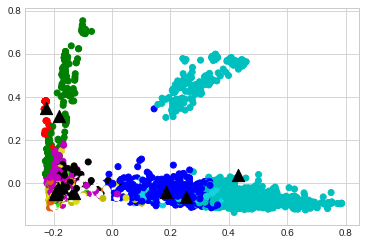

In [87]:
label = ["#e05f14", "#e0dc14", "#2fe014", "#14d2e0", 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
color = [label[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c = color)

centroids = clf.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [94]:
print(ldamodel.print_topics(num_topics=12, num_words=10))

[(0, '0.046*"message" + 0.032*"p" + 0.031*"global" + 0.026*"recipient" + 0.025*"inc" + 0.021*"information" + 0.020*"intended" + 0.019*"communication" + 0.017*"please" + 0.015*"e"'), (1, '0.027*"p" + 0.025*"message" + 0.023*"global" + 0.021*"please" + 0.015*"employee" + 0.014*"intended" + 0.014*"detail" + 0.014*"recipient" + 0.014*"inc" + 0.013*"spglobal"'), (2, '0.020*"please" + 0.011*"hi" + 0.010*"team" + 0.008*"thanks" + 0.008*"letter" + 0.008*"would" + 0.007*"employee" + 0.007*"workday" + 0.007*"need" + 0.007*"time"'), (3, '0.017*"please" + 0.013*"leave" + 0.011*"date" + 0.010*"employee" + 0.009*"hi" + 0.009*"div" + 0.007*"ein" + 0.007*"name" + 0.007*"credit" + 0.007*"mail"')]


# Using Stuff From Another Guy (Should Be Good)

from this guy: https://www.kaggle.com/jannesklaas/19-lstm-for-email-classification

In [140]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [141]:
vocab_size = 20000

In [143]:
tokenizer = Tokenizer(num_words=vocab_size) # Setup tokenizer
tokenizer.fit_on_texts(data["Description"])
sequences = tokenizer.texts_to_sequences(data["Description"]) # Generate sequences

In [144]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 43550 unique tokens.


In [145]:
# index mapping numbers to words!
inv_index = {v: k for k, v in tokenizer.word_index.items()}

In [146]:
# throws it back into text
for w in sequences[1]:
    x = inv_index.get(w)
    print(x,end = ' ')

dear sir madam i tried to change the bank account for salary crediting using the euhreka platform but i keep getting either of these error messages whenever i selected any dbs bank options under the drop down menu i would appreciate your assistance on this matter 

## Text Length

In [147]:
import numpy as np

In [148]:
# Get the average length of a text
avg = sum( map(len, sequences) ) / len(sequences)

# Get the standard deviation of the sequence length
std = np.sqrt(sum( map(lambda x: (len(x) - avg)**2, sequences)) / len(sequences))

avg,std

(147.66028062601188, 139.11513137301557)

In [149]:
max_length = 100

In [150]:
data = pad_sequences(sequences, maxlen=max_length)

In [152]:
import numpy as np
from keras.utils import to_categorical
#labels = to_categorical(np.asarray(target))
print('Shape of data:', data.shape)

Shape of data: (11118, 100)


# Some GloVe Stuff

In [ ]:
glove_dir = 

In [ ]:
embeddings_index = {} # We create a dictionary of word -> embedding
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt')) # Open file